# Introduction to End-to-End RAPIDS Workflows

This tutorial will teach developers how to build an end-to-end workflow with cuDF, cuML, and accelerated XGBoost. You will have the chance to ingest data, conduct ETL, perform EDA, train an XGBoost model, and use SHAP to gain insights into the predictions made by the model. 


We're going to be working with data from the [CitiBike data set](https://ride.citibikenyc.com/system-data). CitiBike is a bike rental company which operates in NYC. Bikes are 'stored' at docking stations around the city, and users can rent a bike and return it to any docking station. We will use the historical information to attempt to predict the time of a users ride, given their starting station, as well as some other information. 


Before we begin, we're going to check what kind of GPU we have using [nvidia-smi](https://developer.nvidia.com/nvidia-system-management-interface). `nvidia-smi` has a whole range of functions described at the link. We are just going to use it to see general information about our GPU.

In [1]:
!nvidia-smi

Tue Mar 29 22:02:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   5545MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Here we see that we have a [16 GB card](https://www.google.com/search?q=mib+to+gb&ei=3s07YsmeELHt9AP4z5zgDg&ved=0ahUKEwjJhbPQ0N32AhWxNn0KHfgnB-wQ4dUDCA4&uact=5&oq=mib+to+gb&gs_lcp=Cgdnd3Mtd2l6EAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAEEcQsAMyBwgAELADEEMyBwgAELADEEMyBwgAELADEEMyBwgAELADEEMyCggAEOQCELADGAEyCggAEOQCELADGAEyCggAEOQCELADGAEyDwguENQCEMgDELADEEMYAjIPCC4Q1AIQyAMQsAMQQxgCSgQIQRgASgQIRhgBUABYAGCABmgBcAF4AIABAIgBAJIBAJgBAMgBEcABAdoBBggBEAEYCdoBBggCEAEYCA&sclient=gws-wiz). If we had multiple cards, we would use `dask_cudf`. This will be covered in another notebook. 

## Importing the data

The CitiBike data is available for download directly from an s3 bucket. In the following cell, we import the data from 2014 only. You can expect the import to take around 30 seconds. 


_You can change the years and the number of years in the cell below by altering `START_YEAR` and `END_YEAR`. Just remember that the `range()` function in Python excludes the `END_YEAR`._

In [2]:
import os
import time
import cupy as cp
import cudf 


START_YEAR = 2014
END_YEAR = 2015 

data_dir = './bike/'
if not os.path.exists(data_dir):
    print('Creating bike directory')
    os.system('mkdir -p ./bike')

url = 'https://s3.amazonaws.com/tripdata/YEARMONTH-citibike-tripdata.zip'
    
def get_year(START_YEAR):
    for month in range(1,13):
        period = str(START_YEAR)+'{:02}'.format(month)
        url_current = url.replace('YEARMONTH', period)
        df = cudf.read_csv(url_current, compression='zip')
        df.to_parquet('./bike/{}/{}.parquet'.format(str(START_YEAR),period), compression='snappy', overwrite=True)
        print("{}/{} saved to local storage".format(START_YEAR, month))
        del df

for year in range(START_YEAR, END_YEAR):
    path = './bike/{}'.format(START_YEAR)
    if not os.path.exists(path):
        os.system('mkdir -p {}'.format(path)+'/')
        print('Downloading to {}'.format(path))
        t0 = time.time()
        get_year(START_YEAR)
        t1 = time.time()
        print("{} download time: {} seconds".format(START_YEAR, round(t1-t0),3))
    else:
        print(str(year)+" already locally available")


2014 already locally available


Below, we read the data we saved to our local hard drive into one large cuDF DataFrame.

In [3]:
months = ['{:02}'.format(month) for month in range(1,13)]
files = ['./bike/'+year+'/'+year+month+'.parquet' for year in os.listdir('bike') for month in months]
df = cudf.read_parquet(files[0])
for file in files[1:12]:
    _df = cudf.read_parquet(file)
    df = cudf.concat([df,_df])

Let's look at the data. 

In [4]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,471,2014-01-01 00:00:06,2014-01-01 00:07:57,2009,Catherine St & Monroe St,40.71117444,-73.99682619,263,Elizabeth St & Hester St,40.71729,-73.996375,16379,Subscriber,1986,1
1,1494,2014-01-01 00:00:38,2014-01-01 00:25:32,536,1 Ave & E 30 St,40.74144387,-73.97536082,259,South St & Whitehall St,40.70122128,-74.01234218,15611,Subscriber,1963,1
2,464,2014-01-01 00:03:59,2014-01-01 00:11:43,228,E 48 St & 3 Ave,40.7546011026,-73.971878855,2022,E 59 St & Sutton Pl,40.75849116,-73.95920622,16613,Subscriber,1991,1
3,373,2014-01-01 00:05:15,2014-01-01 00:11:28,519,Pershing Square N,40.75188406,-73.97770164,526,E 33 St & 5 Ave,40.74765947,-73.98490707,15938,Subscriber,1989,1
4,660,2014-01-01 00:05:18,2014-01-01 00:16:18,83,Atlantic Ave & Fort Greene Pl,40.68382604,-73.97632328,436,Hancock St & Bedford Ave,40.68216564,-73.95399026,19830,Subscriber,1990,1


The spaces in the column names are a pain to work with, so let's change that.

In [5]:
df.columns = [column.replace(' ', '_') for column in df.columns]

Let's see the data types we have from the import.

In [6]:
df.dtypes

tripduration               object
starttime                  object
stoptime                   object
start_station_id           object
start_station_name         object
start_station_latitude     object
start_station_longitude    object
end_station_id             object
end_station_name           object
end_station_latitude       object
end_station_longitude      object
bikeid                     object
usertype                   object
birth_year                 object
gender                     object
dtype: object

We'll have to change some of the types by hand. We'll only have to convert the geographic numbers and trip duration, since they are the only columns where the number represents a cardinal value, and not a category. We'll also want to convert the time stamps to time values. We'll wait to convert the time values until after we've looked at the data because time values do not play nicely with `describe()`, and we'll wait to convert the lat/long values to numbers because it will be valueable to see if they match up with the `*_station_name` values.

In [7]:
df['tripduration'] = df['tripduration'].astype('int32')

Let's take a quick look at the data. We see that when `df.describe()` is given mixed types, we should tell it to include all the data.

In [8]:
df.describe(include='all')

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
count,8081216.0,8081216,8081216,8081216,8081216,8081216,8081216,8081216,8081216,8081216,8081216,8081216,8081216,7868282,8081216
unique,<NA>,6397329,6418883,332,344,344,344,332,344,344,344,6811,2,86,3
top,<NA>,2014-08-29 16:21:53,10/2/2014 08:36:00,521,8 Ave & W 31 St,40.75044999,-73.99481051,497,E 17 St & Broadway,40.73704984,-73.99009296,19931,Subscriber,\N,1
freq,<NA>,11,8,100498,100498,100498,100498,85494,85494,85494,85494,2044,7287721,580778,5635962
mean,851.175207,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
std,4488.807328,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
min,60.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
25%,390.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
50%,616.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
75%,1010.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Data Cleaning and Feature Engineering

It looks like something weird is going on with the Station IDs - there are 332 of them, but 344 Names and 344 Long/Lat values. In 2014, there were around 8M trips. The fleet contained almost 7k bikes. The `birth_year` field seems like it has \N as the most common year which may be missing data. We'll replace it with the average. Oddly, it also looks like `starttime` and `stoptime` are written in different formats - one with dashes and one with slashes. 

Before we begin, let's make sure that our data is in a format that we like. Let's also drop the `start_station_id` and `end_station_id` because at best its redundant and at worst its fishy. 

Let's also drop observations where `tripduration` is negative. Bikes can do a lot of things, but they can't travel back in time. We will drop those observations from the dataframe. We're going to drop `bikeid` from the data set since there's no good reason to think a particular bike would have measureable impact on how long a trip lasts. While we can imagine a broken or otherwise malfunctioning bike leading to issues for the ride, we'll get around that roughly by excluding trips that are less than five minutes from the data set. We know from the link above that the `tripduration` values provided are in seconds. 

In [9]:
df = df.drop(['start_station_id', 'end_station_id', 'bikeid'], axis=1) 

In [10]:
df['tripduration'] = df['tripduration'].where(df['tripduration']>300)
df = df.dropna()

Next, we grab some things from the time fields that will be useful as features for our model. We're doing to create a variable grouping the time of day into one of six periods, the day of week, the month, and then we're going to drop those time variables. The exact second a bike was rented or returned likely has limited explanatory value. 

In [11]:
df['starttime'] = df['starttime'].astype('datetime64[s]')
df['stoptime'] = df['stoptime'].astype('datetime64[s]')
df['start_hour_of_the_day'] = df['starttime'].dt.hour
df['stop_hour_of_the_day'] = df['stoptime'].dt.hour
df['dow'] = df['starttime'].dt.dayofweek
df['month'] = df['starttime'].dt.month
df = df.drop(['starttime', 'stoptime'], axis=1)


na = cp.nan
df['birth_year'] = df['birth_year'].replace('\\N', na).astype('float')
average_birth_year = df['birth_year'].mean()
df['birth_year'] = df['birth_year'].replace(na, average_birth_year)

We're going to calculate [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) for each trip. This will be a useful but imperfect measure of how far a rider traveled. After that, we'll drop lat/long values since they don't contain any information beyond `station_name`.

In [12]:
from cuspatial import haversine_distance

df['start_station_latitude'] = df['start_station_latitude'].astype('float')
df['start_station_longitude'] = df['start_station_longitude'].astype('float')
df['end_station_latitude'] = df['end_station_latitude'].astype('float')
df['end_station_longitude'] = df['end_station_longitude'].astype('float')

df['trip_distance'] = haversine_distance(df['start_station_latitude'], df['start_station_longitude'], df['end_station_latitude'], df['end_station_longitude'])
df = df.drop(['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude'], axis=1)

We're going to use cuML for the next bit of ETL to encode labels into numbers for our analysis. 

In [13]:
import cuml

le = cuml.LabelEncoder()
df['start_station_name'] = le.fit_transform(df['start_station_name'])
df['end_station_name'] = le.fit_transform(df['end_station_name'])
df['usertype'] = le.fit_transform(df['usertype'])
df['gender'] = df['gender'].astype('int')

In [14]:
df.head()

,tripduration,start_station_name,end_station_name,usertype,birth_year,gender,start_hour_of_the_day,stop_hour_of_the_day,dow,month,trip_distance
0,471,68,159,1,1986.0,1,0,0,2,1,0.194074
1,1494,2,261,1,1963.0,1,0,0,2,1,4.293091
2,464,141,154,1,1991.0,1,0,0,2,1,1.414189
3,373,240,127,1,1989.0,1,0,0,2,1,0.811626
4,660,30,184,1,1990.0,1,0,0,2,1,2.483842


Given that we are aiming to predict the length of the ride in seconds, it seems unfair to include both the hour at which the journey starts and the hour at which the journey stops in our feature vectors - let's remove this now, and see how well we can predict trip duration.

In [15]:
df.drop('stop_hour_of_the_day', axis=1, inplace = True)

Now that our data is cleaned up, it's time to see how well we can predict trip duration. We'll start by making a simple XGBoost model and then we will move onto an ensemble with some other methods with cuML.

## XGBoost Prediction Model

First, we want to split our data into train and test sets. We do this with cuML. 

In [16]:
X_train, X_test, y_train, y_test = cuml.train_test_split(df, 'tripduration', train_size=0.8)

In [17]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test) 

In [18]:
params = {
    'learning_rate': 0.3,
    'max_depth': 9,
    'objective': 'reg:squarederror',
    'subsample': 0.8,
    'gamma': 1,
    'disable_default_eval_metric':True, 
    'tree_method':'gpu_hist' 
}

trained_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train')]
)

We'll save the trained model, so that we can re-load it later.

In [19]:
trained_model.save_model("xgb.model")

Now let's see how well our fitted model looks out in the wild.

In [20]:
prediction = trained_model.predict(dtest).astype('int32')
print("RMSE: {}".format(cp.sqrt(cuml.metrics.mean_squared_error(y_test.values, prediction))))

RMSE: 1043.6200377802165


In [32]:
1043/60

17.383333333333333

So we're usually off by about 17 and a half minutes. Looks like there's some room to improve! Why not spend some time changing the model parameters and seeing if you can train a model which gives a smaller RMSE on our test set.

## Model Explainability with SHAP

When using complex models, such as XGBoost, it's not always straightforward to understand the predictions made by the model. In this section we use Shapley Additive Explanation (SHAP) values to gain insight into the Machine Learning model.

Computing SHAP values is a computationally expensive procedure, but we accelerate the procedure by running on NVIDIA GPUs. To save more time, we compute SHAP values on a subset of our data.

Much of the code in this section is taken from this great [blog](https://medium.com/rapids-ai/gpu-accelerated-shap-values-with-xgboost-1-3-and-rapids-587fad6822) on GPU-Accelerated SHAP Values. 

In [22]:
shap_sample = xgb.DMatrix(X_test.sample(frac=0.01))

In [23]:
%%time
trained_model.set_param({"predictor": "gpu_predictor"})
shap_values = trained_model.predict(shap_sample, pred_contribs=True)

CPU times: user 5.04 s, sys: 2.29 s, total: 7.33 s
Wall time: 7.34 s


We can aggregate and visualse these SHAP values to see which of the features in our data had the most impact on the predictions made by our model. 

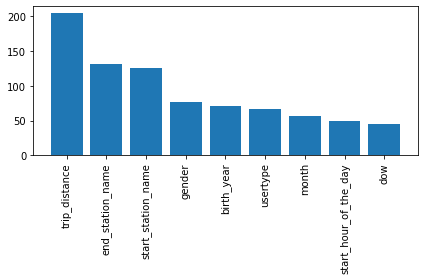

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(feature_names, shap_values):
 # Get the mean absolute contribution for each feature
 aggregate = np.mean(np.abs(shap_values[:, 0:-1]), axis=0)
 # sort by magnitude
 z = [(x, y) for y, x in sorted(zip(aggregate, feature_names), reverse=True)]
 z = list(zip(*z))
 plt.bar(z[0], z[1])
 plt.xticks(rotation=90)
 plt.tight_layout()
 plt.show()


plot_feature_importance(X_test.columns, shap_values)

This shows us that the most important features in predicting ride duration are the length of the trip, and the stations at which the trip began and ended.


We can also use SHAP to consider the importance of interactions between features. This is more computationally expensive again, but can bring valuable insights. The following cell will take around 100 seconds to run. 

In [25]:
%%time
shap_interactions = trained_model.predict(shap_sample, pred_interactions=True)

CPU times: user 57.7 s, sys: 23.8 s, total: 1min 21s
Wall time: 1min 21s


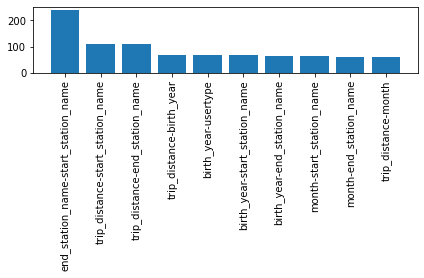

In [26]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
 # Get the mean absolute contribution for each feature interaction
 aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
 interactions = []
 for i in range(aggregate_interactions.shape[0]):
     for j in range(aggregate_interactions.shape[1]):
         if j < i:
             interactions.append(
             (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
 # sort by magnitude
 interactions.sort(key=lambda x: x[1], reverse=True)
 interaction_features, interaction_values = map(tuple, zip(*interactions))
 plt.bar(interaction_features[:k], interaction_values[:k])
 plt.xticks(rotation=90)
 plt.tight_layout()
 plt.show()


plot_top_k_interactions(X_test.columns, shap_interactions, 10)

Here we see that the interactions between the source and destination station name have the greatest impact on the predicted ride duration. 

## Accelerating Inference 

Throughout this notebook we have run most of our computation on the GPU. In this Section, we compare the speed it takes to make predictions on a CPU vs the GPU. 

In [28]:
xgb_features = xgb.DMatrix(X_test.astype("float32"))

### CPU

We first re-load the model from file, as XGBoost caches the results of previous predictions. 

In [30]:
%%time
model = xgb.Booster(model_file="xgb.model")
model.set_param({"predictor": "cpu_predictor"})
predictions = model.predict(xgb_features)

CPU times: user 1min 20s, sys: 13.3 ms, total: 1min 20s
Wall time: 20.5 s


### GPU

Now we can again reload the model, and this time run the same predictions on the GPU

In [31]:
%%time
model = xgb.Booster(model_file="xgb.model")
model.set_param({"predictor": "gpu_predictor"})
predictions = model.predict(xgb_features)

CPU times: user 378 ms, sys: 151 ms, total: 528 ms
Wall time: 499 ms


So you can see that the GPU allows us to make predictions in a fraction of the time taken on CPU. This is ideal for situations requiring real-time inference. 

## Conclusion

In this notebook you've seen how we can use cuML, cuDF and XGBoost to explore and clean data, compute feature vectors and train a machine learning model to predict ride duration on the CitiBike Data Set. 

To find out more, check out [RAPIDS.ai](http://rapids.ai).